In [135]:
try:
    initialized
except NameError:
    ## Matplotlib configuration
    %matplotlib inline
    initialized = True

from sklearn.linear_model import LinearRegression, RidgeCV
from lib import Model, Humanizer, Plotter, TwoMeanModel, Parser
from lib.hbsort import DataFrameBuilder, ExperimentInfo
from mynotebook import *

In [10]:
# Given a stage, z-test on first and nonfirst means to justify node adjustment
exp_info = ExperimentInfo(threads=2, block_size=128 * 1024**2)
df_builder = DataFrameBuilder(threads=exp_info.threads, stage=0)
prof_first_out, prof_nonfirst_out = df_builder.get_profiling_tasks()
tgt0_first_out, tgt0_nonfirst_out = df_builder.get_target_tasks(0)
tgt1_first_out, tgt1_nonfirst_out = df_builder.get_target_tasks(1)

In [12]:
def remove_outliers_concat(*args, concat=True):
    frames = [remove_outliers(df) for df in args]
    res = frames + [pd.concat(frames)]
    return tuple(res)

prof_first, prof_nonfirst, prof = remove_outliers_concat(prof_first_out, prof_nonfirst_out)
tgt0_first, tgt0_nonfirst, tgt0 = remove_outliers_concat(tgt0_first_out, tgt0_nonfirst_out)
tgt1_first, tgt1_nonfirst, tgt1 = remove_outliers_concat(tgt1_first_out, tgt1_nonfirst_out)

In [5]:
# Distributions of first and non-first tasks _are_ different.
import numpy as np


def z_test(dfa, dfb):
    def mean_std(df, n):
        n = str(n)
        group = df.groupby(['input', 'workers'])[['ms']]
        res = group.mean()
        res.columns = ['mean_' + n]  # renaming 'ms' column
        res['std_' + n] = group.std()
        res['samples_' + n] = group.count()
        res['mean_std_' + n] = res['std_' + n] / res['samples_' + n]
        return res
    res = pd.concat([mean_std(dfa, 1), mean_std(dfb, 2)], axis=1)
    res['z'] = (res.mean_1 - res.mean_2) / np.sqrt(res.mean_std_1 ** 2 + res.mean_std_2 ** 2)
    res['different?'] = res.z >= 2.33
    res.loc[np.isnan(res.z),'different?'] = np.nan
    return res


#z_test(prof_first, prof_nonfirst)

In [24]:
model = Model(LinearRegression(), use_log=True)
_prof = pd.concat([tgt0, tgt1])
_tgt = _prof
model.fit(_prof)
model.score(_prof)

[0.3539260809121394,
 ((1, 3284983900), 0.29688379138338006),
 ((2, 3284983900), 0.16136310444755678),
 ((4, 3284983900), 0.2967130755236217),
 ((8, 3284983900), 0.38402169525897684),
 ((12, 3284983900), 0.2203135052535657),
 ((16, 3284983900), 0.25619928372910666),
 ((16, 32849603895), 0.39214556296474273),
 ((32, 32849603895), 0.5173165271462294),
 ((64, 32849603895), 0.6850547455386057),
 ((123, 32849603895), 0.12222501150098827),
 ((128, 32849603895), 0.12367828403511225)]

,input,workers,ms
934,5.51e+08,2,8232


11.099988024736714

array([ 0.06275328,  0.09077249])

,input,workers,ms
951,1.10e+09,2,4269


-14.576728436376115

array([ 0.88109794,  0.40648797])

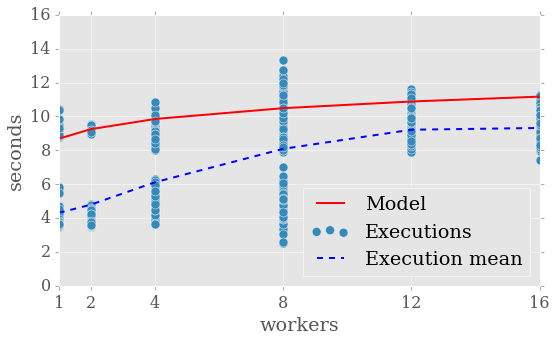

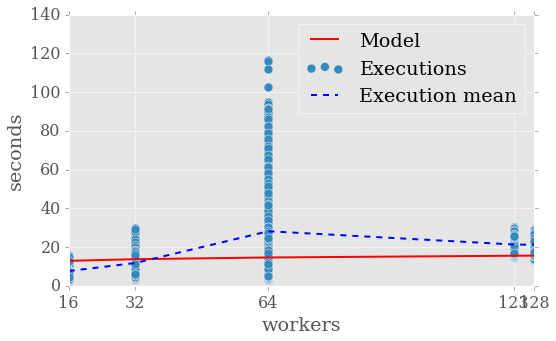

In [167]:
_prof_first = prof_first.copy()
#_prof_first = pd.concat([tgt0_first, tgt1_first])
_prof_nonfirst = prof_nonfirst .copy()
#_prof_nonfirst = pd.concat([tgt0_nonfirst, tgt1_nonfirst])

_prof_first.input /= _prof_first.workers
_prof_nonfirst.input /= _prof_nonfirst.workers

model_first = Model(LinearRegression(), use_log=True)
model_first.fit(_prof_first)
model_nonfirst = Model(LinearRegression(), use_log=True)
model_nonfirst.fit(_prof_nonfirst)

display(_prof_first.sample())
linreg = model_first.get_linreg()
display(linreg.intercept_, linreg.coef_)
display(_prof_nonfirst.sample())
linreg = model_nonfirst.get_linreg()
display(linreg.intercept_, linreg.coef_)

model = TwoMeanModel(model_first, model_nonfirst, exp_info.threads, block_size=exp_info.block_size)
#display(model.score(pd.concat([tgt0, tgt1])))

plotter = Plotter()
plotter.plot_model(model, tgt0)
plotter.plot_model(model, tgt1)

In [ ]:
model_first = Model(LinearRegression(), use_log=True)
model_first.fit(pd.concat([tgt0_first, tgt1_first]))
model_nonfirst = Model(LinearRegression(), use_log=True)
model_nonfirst.fit(pd.concat([tgt0_nonfirst, tgt1_nonfirst]))

model = TwoMeanModel(model_first, model_nonfirst, exp_info.threads, block_size=exp_info.block_size)
plotter = Plotter()
plotter.plot_model(model, tgt0)
plotter.plot_model(model, tgt1)

In [132]:
parser = Parser()
apps = parser.parse_folder('../../../../../..//shared/cadu/noSync/repos/phd_notebook/data/hibench/sort')
recs = []
for app in apps:
    stage = app.stages[0]
    recs.append([app.stages[0].bytes_read, app.slaves, stage.total_tasks])
df = pd.DataFrame.from_records(recs, columns=['input', 'workers', 'tasks'])
len(df)

230

In [134]:
group = df.groupby(['input', 'workers'])
df2 = group.tasks.apply(lambda x: x.unique()[0]).reset_index()
df2['input_per_task'] = df2.input / df2.tasks
block_size = df2.input_per_task.mean()


model = Model(LinearRegression(fit_intercept=True), features=['input'], ycol='tasks', use_log=False)
model.fit(df2)
linear = model.get_linreg()
display(linear.intercept_, linear.coef_)
display(1/linear.coef_[0])
display(model.score(df2))
df2['prediction'] = np.round(model.predict(df2)).astype('int')
df2['prediction2'] = np.ceil(df2.input / (128 * 1024**2 * 1.001)).astype('int')
df2

0.60898290096761798

array([  7.43968396e-09])

134414311.93525973

[0.040505984037824606,
 ((1, 275565819), 0.32955275174139187),
 ((2, 275565819), 0.32955275174139187),
 ((1, 551127932), 0.05815989309415848),
 ((2, 551127932), 0.05815989309415848),
 ((4, 551127932), 0.05815989309415848),
 ((1, 1102242290), 0.02118697979769182),
 ((2, 1102242290), 0.02118697979769182),
 ((4, 1102242290), 0.02118697979769182),
 ((8, 1102242290), 0.02118697979769182),
 ((2, 2204500034), 0.0005744962088111215),
 ((4, 2204500034), 0.0005744962088111215),
 ((8, 2204500034), 0.0005744962088111215),
 ((1, 3284983900), 0.0019289967382430007),
 ((2, 3284983900), 0.0019289967382430007),
 ((4, 3284983900), 0.0019289967382430007),
 ((8, 3284983900), 0.0019289967382430007),
 ((12, 3284983900), 0.0019289967382430007),
 ((16, 3284983900), 0.0019289967382430007),
 ((16, 32849603895), 1.4123716096269256e-06),
 ((32, 32849603895), 1.4123716096269256e-06),
 ((64, 32849603895), 1.4123716096269256e-06),
 ((123, 32849603895), 1.4123716096269256e-06),
 ((128, 32849603895), 1.412371609626925

,input,workers,tasks,input_per_task,prediction,prediction2
0,275565819,1,2,1.38e+08,3,3
1,275565819,2,2,1.38e+08,3,3
2,551127932,1,5,1.10e+08,5,5
3,551127932,2,5,1.10e+08,5,5
4,551127932,4,5,1.10e+08,5,5
5,1102242290,1,9,1.22e+08,9,9
6,1102242290,2,9,1.22e+08,9,9
7,1102242290,4,9,1.22e+08,9,9
8,1102242290,8,9,1.22e+08,9,9
9,2204500034,2,17,1.30e+08,17,17
